# Practice: Dealing with texts using CNN
_Reference: Based on YSDA [materials](https://github.com/yandexdataschool/nlp_course/blob/master/week02_classification/seminar.ipynb). Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

# **Ссылка на колаб:** https://colab.research.google.com/drive/1xGRgUsCwEDsQvKvFAFYchC1qDpsfO5Me?usp=sharing

## About the challenge
For starters, let's download and unpack the data.

You can also get it from [Yandex.Disk](https://yadi.sk/d/vVEOWPFY3NruT7) or [the competition page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [1]:
!curl -L "https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1" -o Train_rev1.csv.tar.gz
!tar xzf Train_rev1.csv.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    66    0    66    0     0    118      0 --:--:-- --:--:-- --:--:--   118
100   299  100   299    0     0    343      0 --:--:-- --:--:-- --:--:--   343
100  119M  100  119M    0     0  41.8M      0  0:00:02  0:00:02 --:--:-- 92.2M


In [2]:
!ls

sample_data  Train_rev1.csv  Train_rev1.csv.tar.gz


In [3]:
import pandas as pd

data = pd.read_csv("Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [4]:
data

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
...,...,...,...,...,...,...,...,...,...,...,...,...
244763,72705211,TEACHER OF SCIENCE,Position: Qualified Teacher Subject/Specialism...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244764,72705212,TEACHER OF BUSINESS STUDIES AND ICT,Position: Qualified Teacher or NQT Subject/Spe...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244765,72705213,ENGLISH TEACHER,Position: Qualified Teacher Subject/Specialism...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244766,72705216,SUPPLY TEACHERS,Position: Qualified Teacher Subject/Specialism...,Wiltshire,Wiltshire,NaN,contract,NaN,Teaching Jobs,450 to 500 per week,22800,hays.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

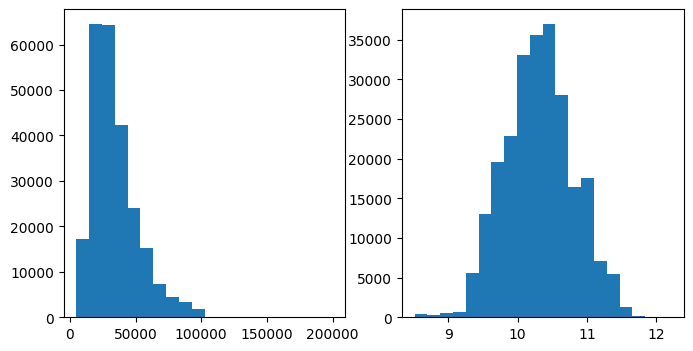

In [5]:
import matplotlib.pyplot as plt
import numpy as np


data["Log1pSalary"] = np.log1p(data["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data["Log1pSalary"], bins=20)

plt.show()

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [6]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna("NaN")
data[text_columns] = data[text_columns].fillna("NaN")

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
58211,68687581,Teacher Waste Management & Recycling (Environm...,ROLE: Waste Awareness Teacher PACKAGE: **** Ba...,Liverpool Merseyside North West,Liverpool,NaN,permanent,Red Kite Selection,Graduate Jobs,"24,000 per annum +Pension+Mobile Phone",24000,totaljobs.com,10.085851
114886,69759433,Commercial Refrigeration Engineer,Our Client a leading provider of hard services...,birmingham,Birmingham,full_time,NaN,NaN,Engineering Jobs,"30,000.00 - 35,000.00 per year Pension",32500,Jobcentre Plus,10.389026
48515,68607968,Bathroom Sales Manager,"Betta Living, a national kitchen, bedroom bath...",Bath,Bath,NaN,NaN,Betta Living,Consultancy Jobs,OTE 50K+,50000,MyUkJobs,10.819798


In [7]:
data.FullDescription[14]

"A well respected restaurant located in the Derby area has a Chef de Partie role available Role: A Chef de Partie who is passionate about working with all fresh produce to a high standard is required to join the brigade of chefs at an award winning restaurant.The restaurant serves **** covers at lunch with a set menu and up to **** covers in the evening for the a la carte menu, as Chef de Partie you will be expected to run a section once fully trained keeping your work space clean and tidy at all times. Requirements: All Chef de Parties applying for this role should already have fresh food experience at this level with the ability to manage a busy section.This role can offer the right candidate excellent opportunities to progress within the team. Benefits Include: Uniform Provided Meals on Duty Excellent Tips – Paid Monthly Excellent Opportunities To Progress If you are interested in this position or would like information on the other positions we are recruiting for or any temporary a

## Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [8]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [9]:
from nltk.tokenize import WordPunctTokenizer


tokenizer = WordPunctTokenizer()

# YOUR CODE HERE
# tokenizer = WordPunctTokenizer()
# print(tokenizer.tokenize(data[50]))
# data_tok = [tokenizer.tokenize(x.lower()) for x in data]
# Lowercase and tokenize titles and descriptions (text_columns).
# Store items as space-separated strings of tokens.
def normalize(text):  # noqa: E302
    tokens = tokenizer.tokenize(str(text).lower())
    return " ".join(tokens)


data[text_columns] = data[text_columns].applymap(normalize)

In [10]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == "mathematical modeller / simulation analyst / opera"
assert data["Title"][54321] == "international digital account manager ( german )"

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [11]:
from collections import Counter


# YOUR CODE HERE
# Count how many times does each token occur in both "Title" and "FullDescription".
# Build a dictionary { token -> count }.
# Hint: you may or may not want to use collections.Counter
# token_counts =
token_counts = Counter()
for text in data[text_columns].values.flatten():
    token_counts.update(text.split(" "))

In [12]:
token_counts

Counter({'engineering': 68563,
         'systems': 77071,
         'analyst': 34427,
         'dorking': 260,
         'surrey': 8237,
         'salary': 93465,
         '****': 681869,
         'k': 77920,
         'our': 223441,
         'client': 198691,
         'is': 599665,
         'located': 7667,
         'in': 1035792,
         ',': 2318606,
         'and': 2657388,
         'are': 428534,
         'looking': 155766,
         'for': 867233,
         'provides': 11180,
         'specialist': 41160,
         'software': 74918,
         'development': 168938,
         'keywords': 4554,
         'mathematical': 1033,
         'modelling': 6534,
         'risk': 26638,
         'analysis': 34076,
         'system': 35689,
         'optimisation': 2801,
         'miser': 8,
         'pioneeer': 1,
         'stress': 1855,
         'engineer': 94623,
         'glasgow': 3333,
         'to': 2019884,
         'we': 238825,
         're': 17471,
         'currently': 54542,
         '

In [13]:
print("Total unique tokens :", len(token_counts))
print("\n".join(map(str, token_counts.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print("Correct!")

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Let's see how many words are there for each count.

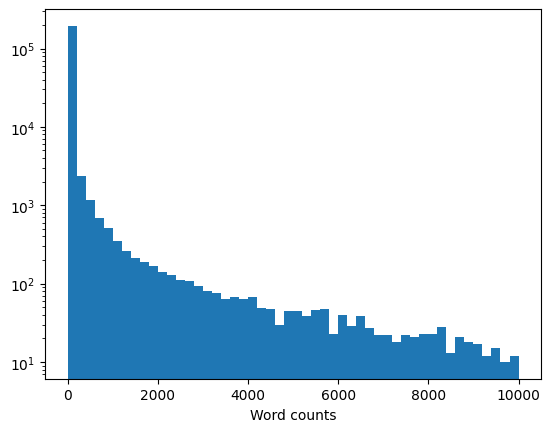

In [14]:
plt.hist(list(token_counts.values()), range=[0, 10 ** 4], bins=50, log=True)
plt.xlabel("Word counts")
plt.show()

Now we will filter tokens a list of all tokens that occur at least 10 times.

In [15]:
min_count = 10

# YOUR CODE HERE
# We shall only consider tokens that had at least min_count occurences.
# Create a list of such tokens.
# tokens = ...
tokens = [token for token, count in token_counts.items() if count >= min_count]

In [16]:
tokens

['engineering',
 'systems',
 'analyst',
 'dorking',
 'surrey',
 'salary',
 '****',
 'k',
 'our',
 'client',
 'is',
 'located',
 'in',
 ',',
 'and',
 'are',
 'looking',
 'for',
 'provides',
 'specialist',
 'software',
 'development',
 'keywords',
 'mathematical',
 'modelling',
 'risk',
 'analysis',
 'system',
 'optimisation',
 'stress',
 'engineer',
 'glasgow',
 'to',
 'we',
 're',
 'currently',
 'talented',
 'engineers',
 'join',
 'growing',
 'team',
 'at',
 'a',
 'variety',
 'of',
 'levels',
 '.',
 'the',
 'roles',
 'ideally',
 'suited',
 'high',
 'calibre',
 'graduates',
 'with',
 'any',
 'level',
 'appropriate',
 'experience',
 'so',
 'that',
 'can',
 'give',
 'you',
 'opportunity',
 'use',
 'your',
 'technical',
 'skills',
 'provide',
 'quality',
 'input',
 'aerospace',
 'projects',
 'spanning',
 'both',
 'aerostructures',
 'aeroengines',
 'return',
 'expect',
 'good',
 'career',
 'opportunities',
 'chance',
 'advancement',
 'personal',
 'professional',
 'support',
 'while',
 'gain

In [17]:
token_counts['????????????????']

4

In [18]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert "me" in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


In [19]:
len(set(tokens))

34158

Build an inverse token index: a dictionary from token to it's index in `tokens`.

In [20]:
# YOUR CODE HERE
# token_to_idx = ...
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

In [21]:
len(token_to_idx)

34158

In [22]:
len(tokens)

34158

In [23]:
# assert isinstance(token_to_idx, dict)
# assert len(token_to_idx) == len(tokens)
# for tok in tokens:
#     assert tokens[token_to_idx[tok]] == tok

# print("Correct!")

In [24]:
# token_to_idx

And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [25]:
UNK_IDX = token_to_idx[UNK]
PAD_IDX = token_to_idx[PAD]


def as_matrix(sequences, max_len=None):
    """Convert a list of tokens into a matrix with padding"""
    if isinstance(sequences[0], str):
        sequences = [seq.split(" ") for seq in sequences]

    sequences_max_len = max(len(seq) for seq in sequences)
    if max_len is None:
        max_len = sequences_max_len
    else:
        max_len = min(sequences_max_len, max_len)

    matrix = np.full((len(sequences), max_len), PAD_IDX)
    for i, seq in enumerate(sequences):
        for j, token in enumerate(seq):
            if j >= max_len:
                break

            matrix[i, j] = token_to_idx.get(token, UNK_IDX)

    return matrix

In [26]:
data["Title"][::100000//2].values

array(['engineering systems analyst',
       'smart metering project manager ( complex network , infrastructure , compl',
       'hr assistant', 'programmes director global defence organisation',
       'senior ec & i engineer'], dtype=object)

In [27]:
print("Lines:")
print("\n".join(data["Title"][::100000//2].values), end="\n\n")
print("Matrix:")
print(as_matrix(data["Title"][::100000//2]))

Lines:
engineering systems analyst
smart metering project manager ( complex network , infrastructure , compl
hr assistant
programmes director global defence organisation
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1     1     1     1     1     1     1]
 [28447 19617 24359 18864    33  6988 20887   158 15824   158     0]
 [15020  2844     1     1     1     1     1     1     1     1     1]
 [24342  9324 13488  8713 22068     1     1     1     1     1     1]
 [27645 10201    16 15215 10804     1     1     1     1     1     1]]


In [28]:
token_to_idx['complete']

6976

Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [29]:
from sklearn.feature_extraction import DictVectorizer


# We only consider top-1k most frequent companies to minimize memory usage
company_counts = Counter(data["Company"])
top_companies = set(name for name, count in company_counts.most_common(1000))
data["Company"] = data["Company"].apply(
    lambda company: company if company in top_companies else "Other"
)

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1));

In [30]:
data[categorical_columns]

,Category,Company,LocationNormalized,ContractType,ContractTime
0,Engineering Jobs,Gregory Martin International,Dorking,NaN,permanent
1,Engineering Jobs,Gregory Martin International,Glasgow,NaN,permanent
2,Engineering Jobs,Gregory Martin International,Hampshire,NaN,permanent
3,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent
4,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent
...,...,...,...,...,...
244763,Teaching Jobs,NaN,Swindon,NaN,contract
244764,Teaching Jobs,NaN,Swindon,NaN,contract
244765,Teaching Jobs,NaN,Swindon,NaN,contract
244766,Teaching Jobs,NaN,Wiltshire,NaN,contract


In [31]:
data[categorical_columns].apply(dict, axis=1)

0         {'Category': 'Engineering Jobs', 'Company': 'G...
1         {'Category': 'Engineering Jobs', 'Company': 'G...
2         {'Category': 'Engineering Jobs', 'Company': 'G...
3         {'Category': 'Engineering Jobs', 'Company': 'G...
4         {'Category': 'Engineering Jobs', 'Company': 'G...
                                ...                        
244763    {'Category': 'Teaching Jobs', 'Company': 'NaN'...
244764    {'Category': 'Teaching Jobs', 'Company': 'NaN'...
244765    {'Category': 'Teaching Jobs', 'Company': 'NaN'...
244766    {'Category': 'Teaching Jobs', 'Company': 'NaN'...
244767    {'Category': 'Teaching Jobs', 'Company': 'NaN'...
Length: 244768, dtype: object

In [32]:
len(categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))[0])

3768

In [33]:
data[categorical_columns].nunique()

Category                29
Company               1001
LocationNormalized    2732
ContractType             3
ContractTime             3
dtype: int64

In [34]:
29 + 1001 + 2732 + 3 + 3

3768

In [35]:
data['Title']

0                               engineering systems analyst
1                                   stress engineer glasgow
2                          modelling and simulation analyst
3         engineering systems analyst / mathematical mod...
4               pioneer , miser engineering systems analyst
                                ...                        
244763                                   teacher of science
244764                  teacher of business studies and ict
244765                                      english teacher
244766                                      supply teachers
244767                                           accountant
Name: Title, Length: 244768, dtype: object

In [36]:
data['FullDescription']

0         engineering systems analyst dorking surrey sal...
1         stress engineer glasgow salary **** to **** we...
2         mathematical modeller / simulation analyst / o...
3         engineering systems analyst / mathematical mod...
4         pioneer , miser engineering systems analyst do...
                                ...                        
244763    position : qualified teacher subject / special...
244764    position : qualified teacher or nqt subject / ...
244765    position : qualified teacher subject / special...
244766    position : qualified teacher subject / special...
244767    this entrepreneurial and growing private equit...
Name: FullDescription, Length: 244768, dtype: object

In [37]:
data[categorical_columns]

,Category,Company,LocationNormalized,ContractType,ContractTime
0,Engineering Jobs,Gregory Martin International,Dorking,NaN,permanent
1,Engineering Jobs,Gregory Martin International,Glasgow,NaN,permanent
2,Engineering Jobs,Gregory Martin International,Hampshire,NaN,permanent
3,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent
4,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent
...,...,...,...,...,...
244763,Teaching Jobs,NaN,Swindon,NaN,contract
244764,Teaching Jobs,NaN,Swindon,NaN,contract
244765,Teaching Jobs,NaN,Swindon,NaN,contract
244766,Teaching Jobs,NaN,Wiltshire,NaN,contract


## The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [38]:
from sklearn.model_selection import train_test_split


data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [39]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a neural-network-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IDX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch["Categorical"] = categorical_vectorizer.transform(
        data[categorical_columns].apply(dict, axis=1)
    )

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1.0 - word_dropout)

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch


def apply_word_dropout(matrix, keep_prob, replace_with=UNK_IDX):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prob, 1 - keep_prob])
    dropout_mask &= matrix != PAD_IDX
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [40]:
example_batch = make_batch(data_train[:3], max_len=10)
print("Example batch:")
print(example_batch)
print("FullDescription shape:", example_batch["FullDescription"].shape)

Example batch:
{'Title': array([[27645, 29893, 33674,     1,     1,     1,     1],
       [29239,   197, 19175, 20042, 15554, 23162,  4051],
       [10609, 30412, 17746,    33,  8705, 29157,    65]]), 'FullDescription': array([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451,
        32939],
       [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,
           82],
       [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412,
        17746]]), 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32)}
FullDescription shape: (3, 10)


In [41]:
example_batch.keys()

dict_keys(['Title', 'FullDescription', 'Categorical', 'Log1pSalary'])

In [42]:
print(example_batch['Title'].shape, example_batch['Title'], sep='\n')

(3, 7)
[[27645 29893 33674     1     1     1     1]
 [29239   197 19175 20042 15554 23162  4051]
 [10609 30412 17746    33  8705 29157    65]]


In [43]:
print(example_batch['FullDescription'].shape, example_batch['FullDescription'], sep='\n')

(3, 10)
[[27645 29893 33674 32939   982 27645 29893 33674 16451 32939]
 [29239   197 19175 20042 15554 23162  4051 25511   907    82]
 [30746 21956 20601  6409 16451  8165 27493   982 30412 17746]]


In [44]:
print(example_batch['Categorical'].shape, example_batch['Categorical'], sep='\n')

(3, 3768)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [45]:
print(example_batch['Log1pSalary'].shape, example_batch['Log1pSalary'], sep='\n')

(3,)
[ 9.71154  10.463132 10.71444 ]


In [46]:
data_train.iloc[0, :]

Id                                                             69173058
Title                                             senior support worker
FullDescription       senior support worker wanted a senior support ...
LocationRaw                       Taunton, Somerset Somerset South West
LocationNormalized                                              Taunton
ContractType                                                        NaN
ContractTime                                                  permanent
Company                                                           Other
Category                                      Healthcare & Nursing Jobs
SalaryRaw                                       15931 - 17082 per annum
SalaryNormalized                                                  16506
SourceName                                                totaljobs.com
Log1pSalary                                                     9.71154
Name: 0, dtype: object

In [47]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """iterates minibatches of data in random order"""
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target

        if not cycle:
            break

To generate minibatches we will use simple pyton generator.

In [48]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)

## Architecture

Our main model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into PyTorch __Sequential__ interface. To build such a network, one will have to use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

But to start with let's build the simple model using only the part of the data. Let's create the baseline solution using only the description part (so it should definetely fit into the Sequential model).

In [49]:
import torch.nn as nn

# Initially, our FullDescription has a shape [batch_size, seq_len].
# After an Embedding layer shape will be [batch_size, seq_len, embedding_size].
# However, Conv1d layer expects batches of shape [batch_size, embedding_size, seq_len].
# We will use this layer to fix this misunderstanding.
class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

In [60]:


simple_model = nn.Sequential(
    # YOUR CODE HERE
    nn.Embedding(len(tokens), 64),
    Reorder(),
    nn.Conv1d(64, 128, kernel_size=3),
    nn.ReLU(),
    nn.Conv1d(128, 128, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Conv1d(128, 128, kernel_size=3),
    nn.ReLU(),
    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(128, 1)
)

In [61]:
list(simple_model.named_parameters())[0][-1].shape

torch.Size([34158, 64])

In [62]:
simple_model.named_parameters()

<generator object Module.named_parameters at 0x7b1ffcbdf6f0>

In [63]:
list(simple_model.named_parameters())[1][-1].shape

torch.Size([128, 64, 3])

__Remember!__ We are working with regression problem and predicting only one number.

In [64]:
import torch


# Check your model. `torch.long` tensors are required for nn.Embedding layers.
simple_model(torch.tensor(batch["Title"], dtype=torch.long))

tensor([[-0.2982],
        [-0.0925],
        [-0.3619]], grad_fn=<AddmmBackward0>)

In [65]:
torch.tensor(batch["Title"], dtype=torch.long).shape

torch.Size([3, 9])

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_model.to(device);

And now simple training pipeline:

In [80]:
from IPython.display import clear_output


epochs = 1
model = simple_model.to('cuda')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
opt = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()


history = []
for epoch in range(epochs):
    for batch, target in iterate_minibatches(data_train):
        # Preprocessing the batch data and target
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        target = torch.tensor(target, device=device)
        emb = nn.Embedding(len(tokens), 64)
        batch = emb(batch).permute((0,2,1))
        predictions = model(batch)
        predictions = predictions.flatten()

        # YOUR CODE HERE
        # Compute loss.
        loss = criterion(predictions, target)

        # YOUR CODE HERE
        # Train with backprop.
        opt.zero_grad()
        loss.backward()
        opt.step()

        history.append(loss.item())
        if len(history) % 10 == 0:
            clear_output(wait=True)
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [ ]:
list(model.named_parameters())[0][0]

'0.weight'

To evaluate the model we can switch it to `eval` state. Let's check the model quality.

In [ ]:
@torch.no_grad()
def evaluate_model(model, data, batch_size=256, name=None, **kwargs):
    squared_error = abs_error = num_samples = 0.0
    data_iterator = iterate_minibatches(data, batch_size, shuffle=False, **kwargs)
    for batch, target in data_iterator:
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        pred = model(batch)[:, 0].cpu().numpy()

        squared_error += np.sum(np.square(pred - target))
        abs_error += np.sum(np.abs(pred - target))
        num_samples += len(target)

    if name is not None:
        print(f"{name}:")

    print(f"MSE: {squared_error / num_samples:.5f}")
    print(f"MAE: {abs_error / num_samples:.5f}")


evaluate_model(simple_model, data_train, name="Train")
evaluate_model(simple_model, data_val, name="Val")

Train:
MSE: 0.24197
MAE: 0.34746
Val:
MSE: 0.26762
MAE: 0.36595


### Bonus area 1: three-headed network.

Now you can try to implement the network we've discussed above. Use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

У нас есть Description Encoder (написанная выше simple_model), нам нужно дописать Title Encoder и Categorical Encoder, а потом соединить их в 1 сеть. По сути, titles и descriptions мы кодируем одинаковым образом, поэтому возьмем уже написанную модель. Отдельно стоит дописать только алгоритм для категориальных фичей (просто воспользуемся линейными слоями).

In [81]:
n_tokens=len(tokens)
n_cat_features=len(categorical_vectorizer.vocabulary_)

In [82]:
class ThreeInputsNet(nn.Module):
    def __init__(
        self,
        n_tokens=len(tokens),
        n_cat_features=len(categorical_vectorizer.vocabulary_),
        hid_size=64,
    ):
        super().__init__()

        self.title_emb = nn.Embedding(n_tokens, hid_size)
        # YOUR CODE HERE
        # Define modules to process the title.

        self.title_encoder = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=3),
        nn.ReLU(),
        nn.Conv1d(128, 128, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Conv1d(128, 128, kernel_size=3),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(1),
        nn.Flatten(),
        nn.Linear(128, 1))

        self.desc_emb = nn.Embedding(n_tokens, hid_size)
        # YOUR CODE HERE
        # Define modules to process the description.

        self.description_encoder = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=3),
        nn.ReLU(),
        nn.Conv1d(128, 128, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Conv1d(128, 128, kernel_size=3),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(1),
        nn.Flatten(),
        nn.Linear(128, 1))

        # YOUR CODE HERE
        # Define modules to process the categorical features.
        self.category_out = nn.Sequential(
            nn.Linear(n_cat_features, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64,1)
        )

        # YOUR CODE HERE
        # Define fully-connected part which will take outputs of
        # three heads and return the result.
        #self.out = nn.Sequential(
            #nn.Linear(256, 64),
            #nn.ReLU(),
            #nn.Linear(64, 1))
        self.out = nn.Linear(3,1)

    def forward(self, whole_input):

        input1, input2, input3 = whole_input

        title_beg = self.title_emb(input1).permute((0, 2, 1))
        # YOUR CODE HERE
        # Process the title.
        title = self.title_encoder(title_beg)

        desc_beg = self.desc_emb(input2).permute((0, 2, 1))
        # YOUR CODE HERE
        # Process the description.
        desc = self.description_encoder(desc_beg)

        # YOUR CODE HERE
        # Process the categorical features.
        category = self.category_out(input3)

        concatenated = torch.cat(
            [
                title.view(title.size(0), -1),
                desc.view(desc.size(0), -1),
                category.view(category.size(0), -1),
            ],
            dim=1,
        )

        # YOUR CODE HERE
        # Process the concatenated features to generate network output.
        out = self.out(concatenated)

        return out

In [83]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)

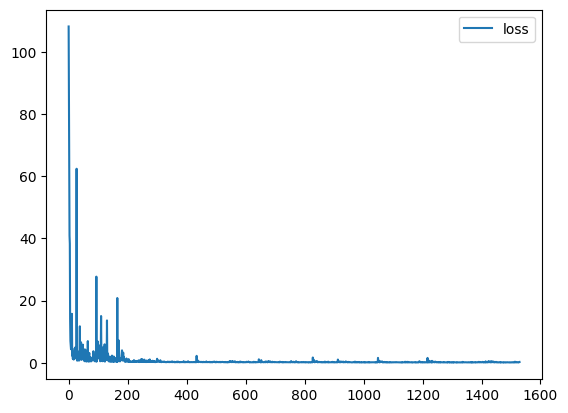

In [84]:
from IPython.display import clear_output


epochs = 2
model = ThreeInputsNet()
opt = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

device = torch.device("cuda")
model.cuda()

history = []
for epoch in range(epochs):
    for batch, target in iterate_minibatches(data_train):
        # Preprocessing the batch data and target
        batch_T = torch.tensor(batch["Title"], dtype=torch.long, device=device)
        batch_D = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        batch_C = torch.tensor(batch["Categorical"], dtype=torch.float, device=device)
        target = torch.tensor(target, device=device)


        predictions = model((batch_T, batch_D, batch_C))
        predictions = predictions.flatten()

        # YOUR CODE HERE
        # Compute loss.
        loss = criterion(predictions, target)

        # YOUR CODE HERE
        # Train with backprop.
        opt.zero_grad()
        loss.backward()
        opt.step()

        history.append(loss.item())
        if len(history) % 10 == 0:
            clear_output(wait=True)
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

Оцениваем качество модели на трейне и вале:

In [85]:

@torch.no_grad()
def evaluate_model_TIN(model, data, batch_size=256, name=None, **kwargs):
    device = torch.device("cuda")
    model.cuda()
    squared_error = abs_error = num_samples = 0.0
    data_iterator = iterate_minibatches(data, batch_size, shuffle=False, **kwargs)
    for batch, target in data_iterator:
        batch_T = torch.tensor(batch["Title"], dtype=torch.long, device=device)
        batch_D = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        batch_C = torch.tensor(batch["Categorical"], dtype=torch.float, device=device)
        pred = model((batch_T, batch_D, batch_C))[:, 0].cpu().numpy()

        squared_error += np.sum(np.square(pred - target))
        abs_error += np.sum(np.abs(pred - target))
        num_samples += len(target)

    if name is not None:
        print(f"{name}:")

    print(f"MSE: {squared_error / num_samples:.5f}")
    print(f"MAE: {abs_error / num_samples:.5f}")

evaluate_model_TIN(model, data_train, name="Train")
evaluate_model_TIN(model, data_val, name="Val")

Train:
MSE: 0.13419
MAE: 0.25784
Val:
MSE: 0.14769
MAE: 0.27120


Получаем MSE = 0.14769, MAE = 0.27120 на валидационной выборке, задача выполнена!

### Bonus area 2: comparing RNN to CNN
Try implementing simple RNN (or LSTM) and applying it to this task. Compare the quality/performance of these networks.
*Hint: try to build networks with ~same number of paremeters.*

In [ ]:
# YOUR CODE HERE

### Bonus area 3: fixing the data leaks
Fix the data leak we ignored in the beginning of the __Deep Learning part__. Compare results with and without data leaks using same architectures and training time.


In [ ]:
# YOUR CODE HERE

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)